<a href="https://colab.research.google.com/github/pablo-arantes/ermsfkit/blob/main/eRMSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **eRMSF: A Python Package for Ensemble RMSF Analysis of Molecular Dynamics and Structural Ensembles**

Here, we introduce a jupyter notebook to run eRMSF, a fast and user-friendly Python package built with MDAKit from MD-Analysis, designed to perform ensemble-based Root Mean Square Fluctuation (RMSF) analyses. Users can easily customize atom, residue, or region selections, tailoring analyses to specific research questions. This approach delivers high-resolution insights into localized motions, complements global stability assessments, and reveals dynamic regions often overlooked by single-method analyses.

---

**IMPORTANT**: Please set the runtime type to CPU. You don't need GPU to run eRMSF.

**Bugs**
- If you encounter any bugs, please report the issue to https://github.com/pablo-arantes/ermsfkit/issues

**Acknowledgments**

- We would like to thank the MDAnalysis team for developing an excellent and open-source code.


- For related notebooks see: https://github.com/pablo-arantes/ermsfkit

- Please cite MDAnalysis when using eRMSF in published work.

- The formal publication of eRMSF is under peer review at the moment, stay tuned.

In [ ]:
#@title **Install dependencies**
#@markdown It will take a few seconds, don't worry. ;-)
# install dependencies

!pip install 'ermsfkit[demo] @ git+https://github.com/pablo-arantes/ermsfkit.git' > /dev/null 2>&1
!pip install Py3Dmol > /dev/null 2>&1

✅ Using your uploaded file: trajectory.dcd


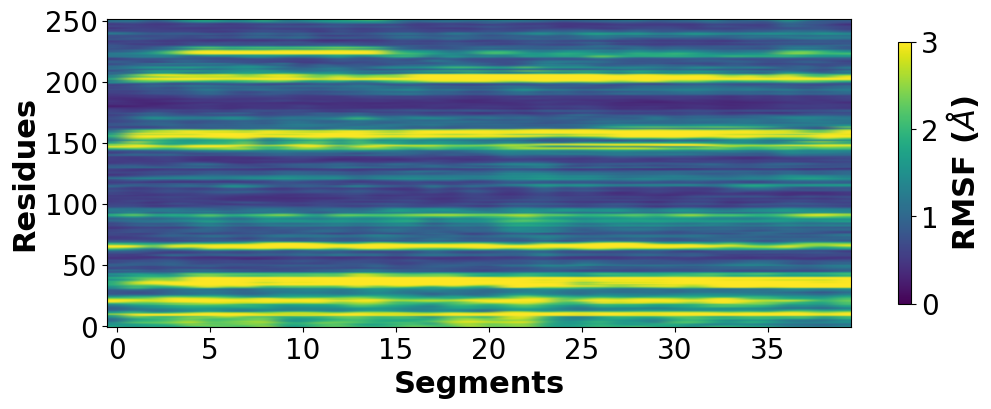

In [28]:
#@title **eRMSF Analysis**

#@markdown **Please Provide the Required Information**

# @markdown File Selection

# @markdown Choose whether to use the provided example files or upload your own.
# @markdown - If you select **"example"**, the default example files will be used.
# @markdown - If you select **"own"**, please upload your trajectory files (e.g. `trajectory.dcd`, `topology.pdb`) to this Colab session first.


files = "own"  # @param ["example", "own"]

#@markdown Enter the filename of your topology and trajectory.

top = "topology.pdb" #@param {type:"string"}

traj = 'trajectory.dcd' #@param {type:"string"}

# @markdown Select the skip parameter, which defines the number of frames per segment.

Skip = 10 #@param {type:"slider", min:1, max:10, step:1}

output_name = 'eRMSF.png' #@param {type:"string"}

#@markdown Define the minimum and maximum values (in angstrons) for the heatmap color scale.
vmin = 0 #@param {type:"number"}
vmax = 3 #@param {type:"number"}


if files == "own":
    import os

    # Check if user uploaded a trajectory
    if not os.path.exists(f"{traj}"):
        raise FileNotFoundError(
            f"❌ {traj} not found. Please upload your file to the Colab session."
        )
    else:
        print(f"✅ Using your uploaded file: {traj}")
else:
    print("📂 Using the provided example files.")

import warnings
warnings.filterwarnings('ignore', category=SyntaxWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

from eRMSF import ermsfkit
import MDAnalysis as mda
import matplotlib.pyplot as plt
from MDAnalysis.tests.datafiles import PSF, DCD
from MDAnalysis.analysis import rms, align
import numpy as np


if files == "example":
  u = mda.Universe(PSF, DCD)
else:
  u = mda.Universe(top, traj)

average = align.AverageStructure(u, u, select='protein and name CA',
                                 ref_frame=0).run()
ref = average.results.universe

aligner = align.AlignTraj(u, ref,
                          select='protein and name CA',
                          in_memory=True).run()

protein = u.select_atoms('protein and name CA')

# Initialize the tRMSF analysis
ermsf_analysis = ermsfkit(protein, skip=Skip, reference_frame=0)

# Run the tRMSF analysis
ermsf_analysis.run()

# Get the results
results = ermsf_analysis.results.ermsf

# Plot the heatmap
plt.figure(figsize=(12, 4))
plt.imshow(results, cmap='viridis', alpha=1, aspect='auto',vmin =vmin, vmax=vmax, origin='lower', interpolation="bicubic")

plt.xlabel('Segments', fontsize=22, fontweight='bold')
plt.ylabel('Residues', fontsize=22, fontweight='bold')
cbar1 = plt.colorbar(orientation="vertical", shrink=0.85, pad=0.05)
cbar1.ax.tick_params(labelsize=20)
cbar1.set_label(r'RMSF ($\AA$)', fontsize=22, fontweight='bold')
plt.yticks(size=20)
plt.xticks(size=20)
plt.savefig(output_name, dpi=600, bbox_inches='tight')

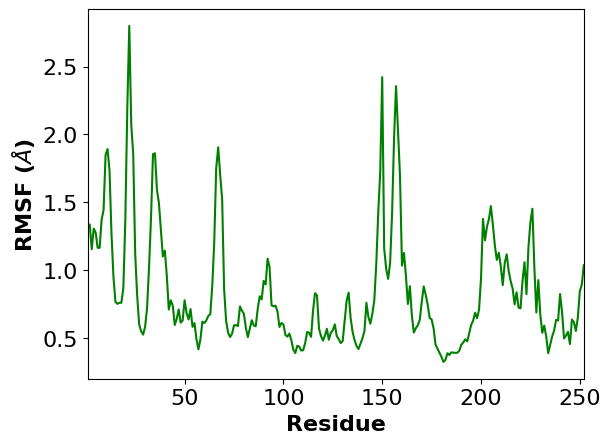

In [25]:
#@title **Regular RMSF Analysis**

#@markdown This plot shows the regular Root Mean Square Fluctuation (RMSF) for the protein, averaged over the entire trajectory. This can be compared to the eRMSF heatmap above to see how fluctuations vary across different segments of the trajectory.

output_name = 'RMSF.png' #@param {type:"string"}

from MDAnalysis.analysis.rms import RMSF
import os
sele = u.select_atoms("name CA")

R = RMSF(sele).run()
rmsf = R.results.rmsf
residues = sele.residues.resids

plt.plot(residues, rmsf, color = "green")
plt.xlabel("Residue", fontsize = 16, fontweight = 'bold')
plt.ylabel(r"RMSF ($\AA$)", fontsize = 16, fontweight = 'bold')
plt.xticks(size=16)
plt.xlim(residues[0], residues[-1])

plt.yticks(fontsize = 16)
plt.savefig(os.path.join(output_name), dpi=600, bbox_inches='tight')

In [26]:
#@title **Save the RMSF values as custom B factors**
#@markdown **Provide output file names below:**
import pandas as pd
import warnings
warnings.filterwarnings('ignore', category=SyntaxWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

Output_name = 'PDB_RMSF' #@param {type:"string"}

pdb_rmsf = os.path.join(str(Output_name) + ".pdb")

sele = u.select_atoms("name CA")

R = RMSF(sele).run()
rmsf_data = pd.DataFrame(R.rmsf,index=sele.resnums,columns=['RMSF']) #Saving the RMSF value for every aC residue
rmsf_3d=[]
protein_write = u.select_atoms("protein")
protein_write.write("protein_bfactor.pdb")
u1=mda.Universe("protein_bfactor.pdb","protein_bfactor.pdb")
u1.add_TopologyAttr('tempfactors') #Initialization of B factors (tempfactors) by MDA in the Universe atoms
for atom in u1.atoms:
    rmsf_3d.append(rmsf_data.loc[atom.resid,'RMSF']) #A new list of RMSF must be created by ATOM. Our table has this values per aC. We can create a longer list easily
with mda.Writer(pdb_rmsf, u1) as PDB: #This is the functionality from MDA which allos us to save PDB files.
    for ts in u1.trajectory: #I'll save just the first frame in PDB as snapshot
        u1.atoms.tempfactors = rmsf_3d #This adds the custom B factors to the PDB snapshot
        PDB.write(u1.atoms)

pdb_check = os.path.exists(pdb_rmsf)
if pdb_check == True:
  print("Successfully generated PDB file! :-)")
else:
  print("ERROR: Check your inputs! ")

Successfully generated PDB file! :-)


/usr/local/lib/python3.12/dist-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

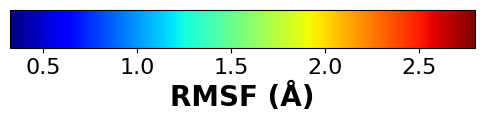

In [27]:
#@title **Display 3D structure with RMSF values** {run: "auto"}
import py3Dmol
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl

color = "RMSF" #@param ["chain", "RMSF", "rainbow"]


def show_pdb(color="RMSF"):
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_rmsf,'r').read(),'pdb')

  # if color == "RMSF":
  #   view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':min(rmsf_data['RMSF']),'max':max(rmsf_data['RMSF'])}}})
  if color == "RMSF":
    # invert colors by swapping min and max
    view.setStyle({
        'cartoon': {
            'colorscheme': {
                'prop': 'b',
                'gradient': 'roygb',  # keep the default gradient
                'min': max(rmsf_data['RMSF']),  # swap min/max
                'max': min(rmsf_data['RMSF'])
            }
        }
    })
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),list("ABCDEFGH"),
                     ["lime","cyan","magenta","yellow","salmon","white","blue","orange"]):
      view.setStyle({'chain':chain},{'cartoon': {'color':color}})

  view.zoomTo()
  return view


show_pdb(color).show()

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=min(rmsf_data['RMSF']), vmax=max(rmsf_data['RMSF']))

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,norm=norm,orientation='horizontal')
cb1.set_label('RMSF (Å)',fontsize=20,fontweight='bold')
cb1.ax.tick_params(labelsize=16)
fig.show()

In [32]:
#@title **Download Results**

#@markdown This will create a zip file containing all the generated `.png` and `.pdb` files for download.

import os
import shutil
import tempfile
from google.colab import files

# List all png and pdb files
file_list = [f for f in os.listdir('.') if f.endswith('.png') or f.endswith('.pdb')]

# Create a temporary directory
with tempfile.TemporaryDirectory() as tmpdir:
    # Copy only the desired files to the temporary directory
    for filename in file_list:
        shutil.copy2(filename, tmpdir)

    # Create a zip archive from the temporary directory
    zip_filename = "ermsf_results.zip"
    shutil.make_archive(zip_filename.replace('.zip', ''), 'zip', tmpdir)

print(f"Created {zip_filename}. You can download it from the file browser.")
files.download(zip_filename)

Created ermsf_results.zip. You can download it from the file browser.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>